# CNNAutoencoder+OneClassSVM



In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve

In [3]:

Dataset = dataset.dataset("Obrid_AE", "data")
Dataset.concat_data("sample_data",500)
Dataset = dataset.dataset("Obrid_AE", "test")
print("----------------------")
Dataset.concat_data("sample_test",100)
print("----------------------")
data = Dataset.read_savedata("sample_test")
print(data.shape[0])
print("----------------------")
data, test_data , anomaly_data= Dataset.read_traindata("sample_data", "sample_test", 1000, 256, 1)


(500, 256)
(500, 256)
----------------------
(100, 256)
(100, 256)
----------------------
(100, 256)
100
----------------------
(500, 256)
(100, 256)
1148 0
rate 0.9
data.shape[0]: 500
rate 450
TrainData (1000, 256, 1, 1, 256)
TestData (50, 256)
ÄnomalyDta (100, 256)


学習データ数:452個

In [4]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

##  一次元CNN
カーネルのサイズとか色々変えながらやってみてください。
前結合層も組み込もうとしてたけど、あまり具合が良くなさそうだったためコメントアウトしてます。
丸め誤差的なので出力サイズが256にならない現象が起きてるので、output_paddingなど追加した、ここら辺のパラメタを使えば埋め合わせができる

## 学習

In [5]:

losslist=[]

model = mainmodel.Autoencoder2()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

outputs = []
#テンソル型に変換
data = torch.from_numpy(data.astype(np.float32)).clone()
for epoch in data:
    for data in epoch:
        recon = model(data)
#         print(recon.shape, data.shape)
        loss = criterion(recon, data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#     print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    print('Loss:{:.4f}'.format(float(loss)))
    losslist.append(loss)
    outputs.append((epoch, data, recon))

Loss:0.1108
Loss:0.0220
Loss:0.0126
Loss:0.0066
Loss:0.0043
Loss:0.0032
Loss:0.0053
Loss:0.0297
Loss:0.1135
Loss:0.0023
Loss:0.0023
Loss:0.0233
Loss:0.0071
Loss:0.0011
Loss:0.0030
Loss:0.0075
Loss:0.0034
Loss:0.0012
Loss:0.0010
Loss:0.0055
Loss:0.0011
Loss:0.0019
Loss:0.0009
Loss:0.0013
Loss:0.0016
Loss:0.0078
Loss:0.0012
Loss:0.0016
Loss:0.0011
Loss:0.0020
Loss:0.0018
Loss:0.0017
Loss:0.0013
Loss:0.0017
Loss:0.0015
Loss:0.0015
Loss:0.0013
Loss:0.0007
Loss:0.0014
Loss:0.0012
Loss:0.0016
Loss:0.0012
Loss:0.0018
Loss:0.0011
Loss:0.0011
Loss:0.0013
Loss:0.0013
Loss:0.0014
Loss:0.0011
Loss:0.0013
Loss:0.0016
Loss:0.0018
Loss:0.0015
Loss:0.0014
Loss:0.0051
Loss:0.0007
Loss:0.0011
Loss:0.0163
Loss:0.0005
Loss:0.0004
Loss:0.0010
Loss:0.0004
Loss:0.0013
Loss:0.0011
Loss:0.0010
Loss:0.0007
Loss:0.0012
Loss:0.0008
Loss:0.0010
Loss:0.0005
Loss:0.0014
Loss:0.0012
Loss:0.0007
Loss:0.0011
Loss:0.0017
Loss:0.0007
Loss:0.0009
Loss:0.0013
Loss:0.0009
Loss:0.0010
Loss:0.0013
Loss:0.0012
Loss:0.0007
Loss

# ocsvm

In [21]:

Dataset = dataset.dataset("Obrid_AE", "data")
Dataset.concat_data("sample_data",500)
Dataset = dataset.dataset("Obrid_AE", "test")
print("----------------------")
Dataset.concat_data("sample_test",100)
print("----------------------")
data = Dataset.read_savedata("sample_test")
print(data.shape[0])
print("----------------------")
data, test_data , anomaly_data= Dataset.read_traindata("sample_data", "sample_test", 1000, 256, 1)

input_model = mainmodel.Autoencoder2()
input_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_model = mainmodel.Autoencoder2().to(device)
input_model.load_state_dict(torch.load("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/program/syuron/model_data/20211203/newmodel.pth", map_location=device))

# data = torch.from_numpy(data.astype(np.float32)).clone()
test = torch.from_numpy(test_data.astype(np.float32)).clone()
test_anomaly = torch.from_numpy(anomaly_data.astype(np.float32)).clone()
svm = OneClassSVM()
x_normal_train = input_model.encoder(data).numpy()
x_test = input_model.encoder(test).numpy()
x_test_anomaly = input_model.encoder(test_anomaly).numpy()
svm.fit(x_normal_train)
y_score = svm.decision_function(x_test)
auc_ae = roc_auc_score(y_test,y_score)
fpr_ae, tpr_ae, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr_baseline, tpr_baseline, label='baseline(AUC = %.2f)'%auc_baseline)
plt.plot(fpr_ae, tpr_ae, label='Auto Encoder(AUC = %.2f)'%auc_ae)
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

(500, 256)
(500, 256)
----------------------
(100, 256)
(100, 256)
----------------------
(100, 256)
100
----------------------
(500, 256)
(100, 256)
1148 0
rate 0.9
data.shape[0]: 500
rate 450
TrainData (1000, 256, 1, 1, 256)
TestData (50, 256)
ÄnomalyDta (100, 256)


TypeError: conv1d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


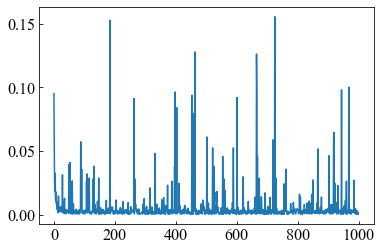

In [5]:
# plt.ylim(0,0.01)
plt.plot(losslist)

plt.savefig('loss.eps', bbox_inches="tight", pad_inches=0.05) 

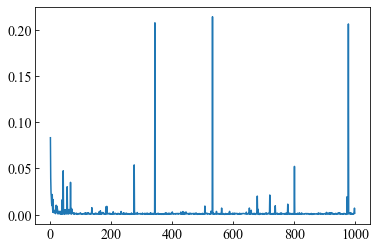

In [5]:
plt.plot(losslist)

plt.savefig('loss.eps', bbox_inches="tight", pad_inches=0.05) 

## 学習過程

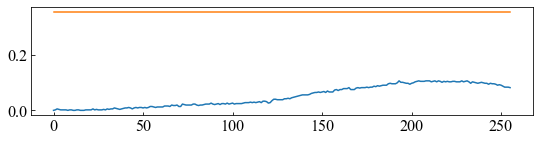

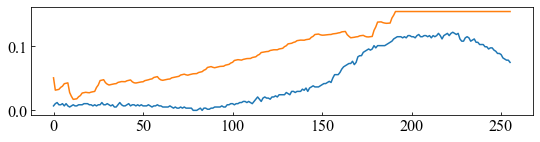

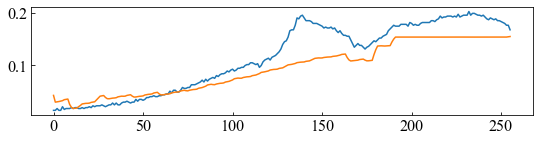

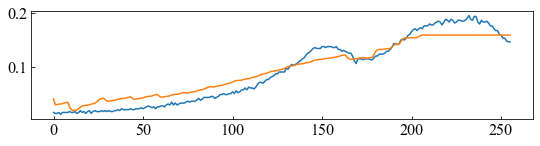

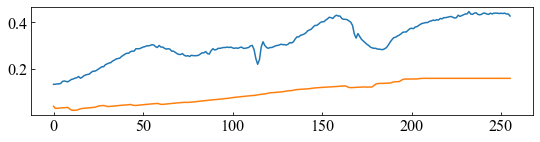

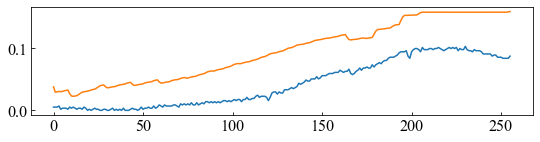

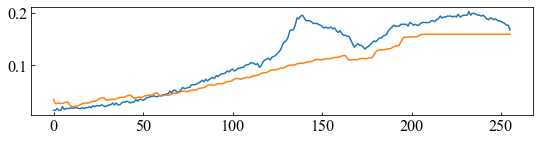

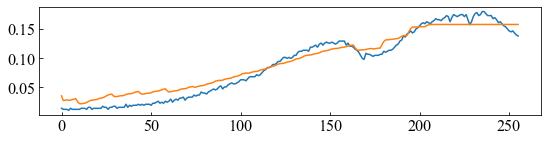

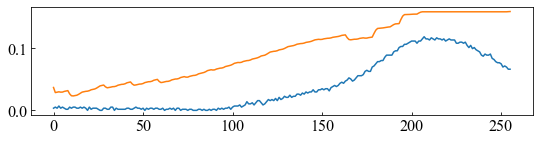

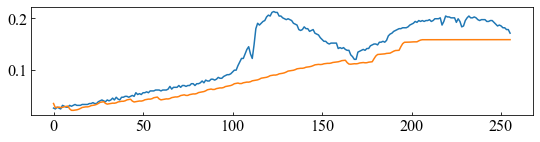

In [6]:
import numpy as np
model_name = "epoch1000"
ModelEdit = mainmodel.Modeledit("Obrid_AE")
ModelEdit.save_model(model, model_name) 
epoch_num = 1000
for k in range(0, epoch_num, int(epoch_num/10)):
    plt.figure(figsize=(9, 2))
    datas = outputs[k][1].flatten().detach().numpy()
    recon = outputs[k][2].flatten().detach().numpy()
    # print(data.flatten())
    # print(recon.flatten())
    plt.plot(datas)
    plt.plot(recon)

In [17]:
import dataloader
num = 1000
input_model = mainmodel.Autoencoder2()
# Dataset.savenumpy(data, test_data, anomaly_data, num)

new_model = mainmodel.Modeledit("Obrid_AE").read_model(input_model,"Obrid_AE/model_data/20211202/epoch1000.pth")
recon_list, encoded_list, input_list = dataloader.ocsvm_dataset(new_model, data)


NameError: name 'test_data' is not defined

## 異常検知

<class 'torch.Tensor'>


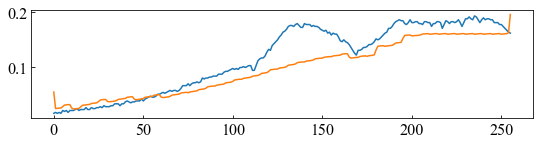

normal:5.835753319784999


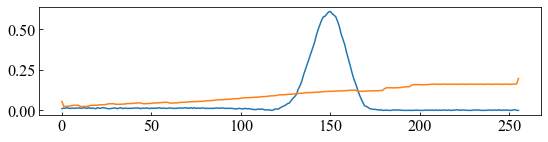

anomarly:28.107090092264116
anomaly
<class 'torch.Tensor'>


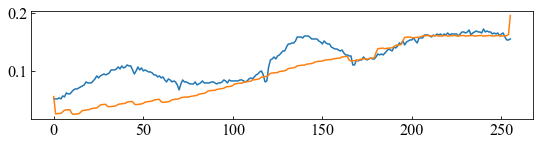

normal:5.743506774306297


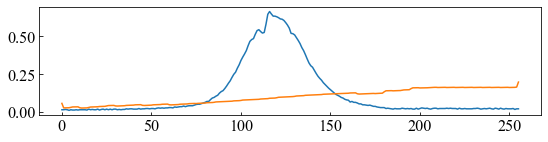

anomarly:33.14495150372386
anomaly
<class 'torch.Tensor'>


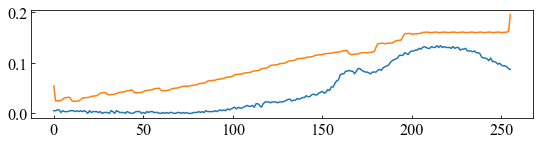

normal:12.507032012566924
anomaly


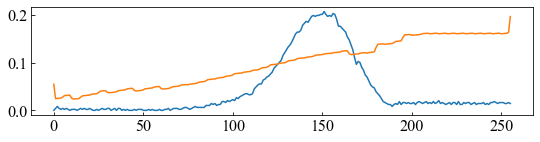

anomarly:18.582450207322836
anomaly
<class 'torch.Tensor'>


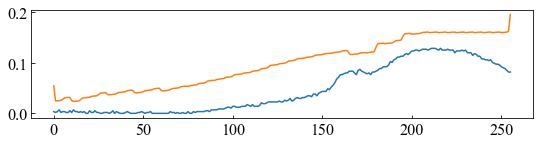

normal:12.719575518742204
anomaly


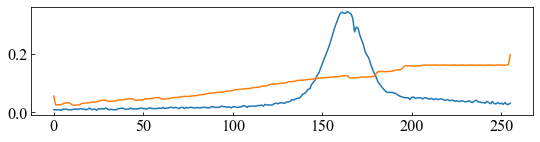

anomarly:18.56795322522521
anomaly
<class 'torch.Tensor'>


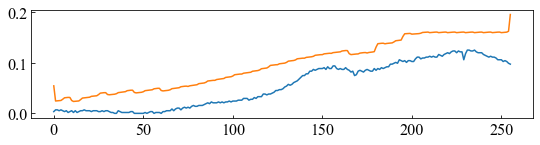

normal:10.688216604292393
anomaly


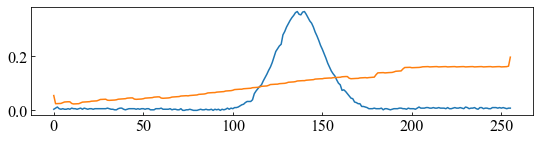

anomarly:23.934585288167
anomaly


IndexError: index 50 is out of bounds for axis 0 with size 50

In [22]:
# num = 5

for i in range(anomaly_data.shape[0]):
    if i % 10 == 0:
        data0 =  torch.from_numpy((test_data[i]).astype(np.float32)).clone()
        test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
        print(type(data0))
        plt.figure(figsize=(9, 2))
        # data = data0.numpy()
        data = data0[np.newaxis, np.newaxis, :]
        recon = model(data).detach().numpy()
        plt.plot(data0.numpy())
        plt.plot(recon.flatten())
        plt.show()
        
        anomalypoint=sum(abs(recon.flatten()-data0.numpy()))
        print("normal:"+str(anomalypoint))
        if(anomalypoint>10):
            print("anomaly")
            
        plt.figure(figsize=(9, 2))
        # data = test0.numpy()
        data = test0[np.newaxis, np.newaxis, :]
        recon = model(data).detach().numpy()
        plt.plot(test0.numpy(),label="testdata")
        plt.plot(recon.flatten(),label="recondata")
        plt.show()
        
        anomalypoint=sum(abs(recon.flatten()-test0.numpy()))
        print("anomarly:"+str(anomalypoint))
        if(anomalypoint>10):
            print("anomaly")

anomalyData:100
Correct[%]100.0%
Error:8
anomalyScore:5.178841771932127


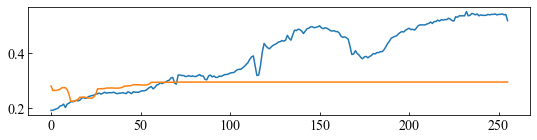

Error:15
anomalyScore:0.43659866105974743


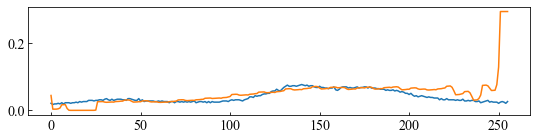

normalData:50
Correct[%]96.0%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


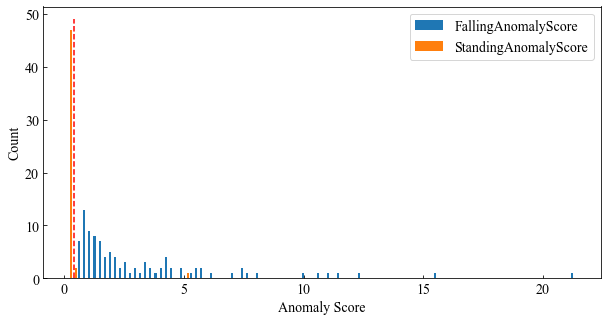

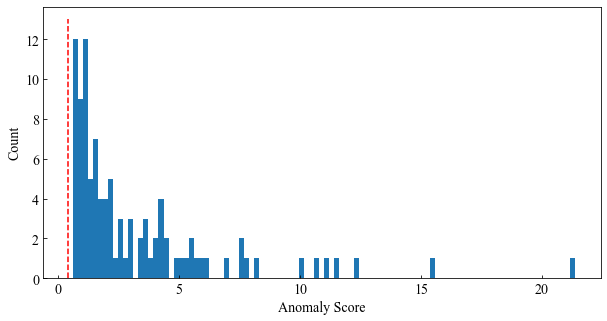

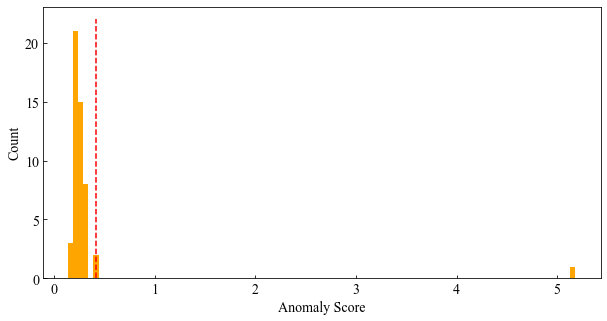

In [8]:
AnomalyCorrectPoint = 0
StandardCorrectPoint = 0
anomalyScoreList=[]
thr = 0.42
for i in range(anomaly_data.shape[0]):
        test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
        data = test0[np.newaxis, np.newaxis, :]
        recon = model(data).detach().numpy()

        anomalyScoreList.append(sum((recon.flatten()-test0.numpy())**2))
        if(anomalyScoreList[i]>thr):
            AnomalyCorrectPoint += 1
        
print('anomalyData:'+str(anomaly_data.shape[0]))
print('Correct[%]'+str(100*AnomalyCorrectPoint/anomaly_data.shape[0])+'%')
fallingAnomalyScore = anomalyScoreList

StandardCorrectPoint = 0
anomalyScoreList=[]
for i in range(test_data.shape[0]):
        data0 =  torch.from_numpy((test_data[i]).astype(np.float32)).clone()
        test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
        data = data0[np.newaxis, np.newaxis, :]
        recon = model(data).detach().numpy()

        anomalyScoreList.append(sum((recon.flatten()-data0.numpy())**2))
        
        if(anomalyScoreList[i]<=thr):
            StandardCorrectPoint += 1
        else:
            print('Error:'+str(i))
            print('anomalyScore:'+str(anomalyScoreList[i]))
            plt.figure(figsize=(9, 2))
            plt.plot(data0.numpy())
            plt.plot(recon.flatten())
            plt.show()             
print('normalData:'+str(test_data.shape[0]))
print('Correct[%]'+str(100*StandardCorrectPoint/test_data.shape[0])+'%')

plt.figure(figsize=(10, 5))
plt.hist([fallingAnomalyScore,anomalyScoreList],label=['FallingAnomalyScore','StandingAnomalyScore'],bins=100)
plt.vlines([thr], 0, 49, "red", linestyles='dashed')
plt.legend()
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.savefig("scoreHist.eps", bbox_inches="tight", pad_inches=0.05) 
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(fallingAnomalyScore,label='FallingAnomalyScore',bins=100)
plt.vlines([thr], 0, 13, "red", linestyles='dashed',label='threshold')
# plt.legend()
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.savefig("fallingScoreHist.eps", bbox_inches="tight", pad_inches=0.05) 
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(anomalyScoreList,label='StandingAnomalyScore',bins=100,color='orange')
plt.vlines([thr], 0, 22, "red", linestyles='dashed')
# plt.legend()
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.savefig("standingScoreHist.eps", bbox_inches="tight", pad_inches=0.05) 
plt.show()

**good Data

anomalyData:99
Correct[%]100.0%
normalData:51
Correct[%]98.03921568627452%

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


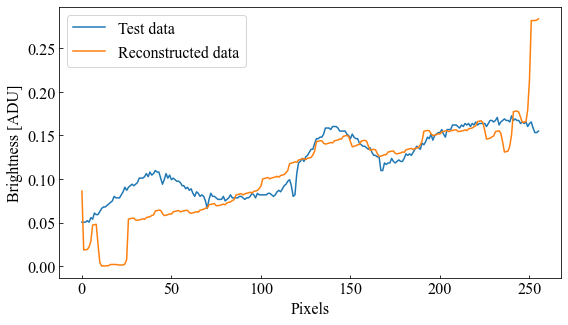

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0.2635918158405133


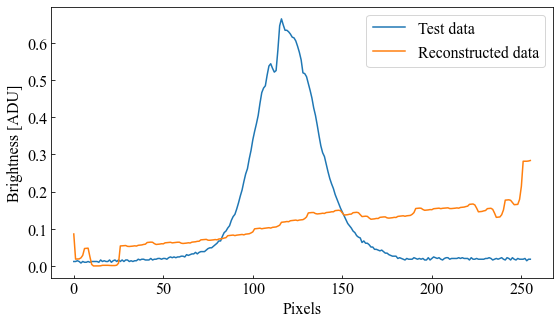

8.637063375676007


In [19]:
i=10
anomalypoint=0
data0 =  torch.from_numpy((test_data[i]).astype(np.float32)).clone()
test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()

plt.figure(figsize=(9, 5))
# data = data0.numpy()
data = data0[np.newaxis, np.newaxis, :]
recon = model(data).detach().numpy()

plt.plot(data0.numpy(),label="Test data")
plt.ylabel('Brightness [ADU]')
plt.xlabel('Pixels')
plt.plot(recon.flatten(),label="Reconstructed data")
plt.legend()
plt.savefig("standrecon.eps", bbox_inches="tight", pad_inches=0.05) 
plt.show()
anomalypoint=sum((recon.flatten()-data0.numpy())**2)
print(anomalypoint)

recon = model(data).detach().numpy()
plt.figure(figsize=(9,5))
plt.ylabel('Brightness [ADU]')
plt.xlabel('Pixels')
plt.plot(test0.numpy(),label="Test data")
plt.plot(recon.flatten(),label="Reconstructed data")
plt.legend()
plt.savefig("anomalyrecon.eps", bbox_inches="tight", pad_inches=0.05) 
plt.show()
anomalypoint=sum((recon.flatten()-test0.numpy())**2)
print(anomalypoint)

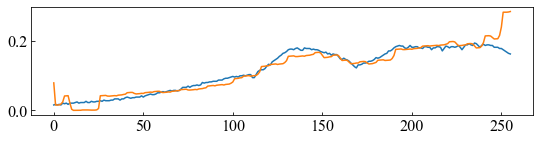

normal:3.4159946152940392
tensor([-2.0088,  5.9230, -6.0056], grad_fn=<AddBackward0>)


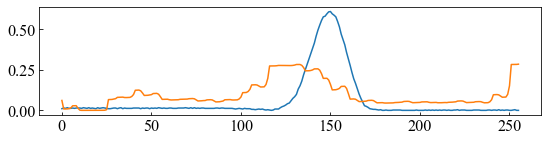

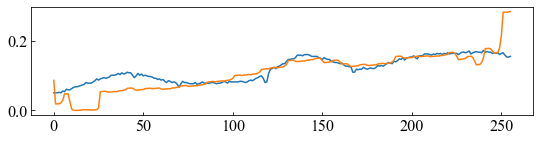

normal:5.325007740408182
tensor([-2.4498,  1.9974, -5.9208], grad_fn=<AddBackward0>)


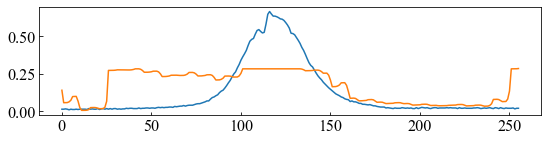

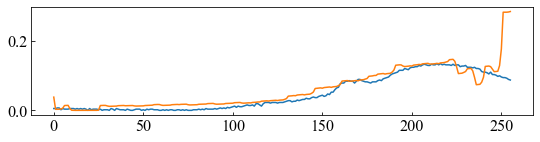

normal:3.8913547495758394
tensor([-1.1921,  6.2680, -5.8862], grad_fn=<AddBackward0>)


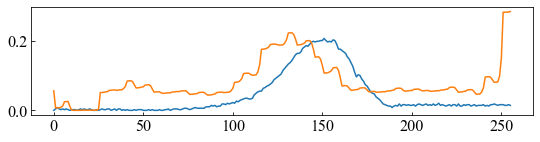

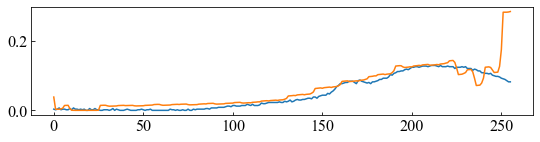

normal:3.8450398312779726
tensor([ 0.9542,  7.8163, -5.0757], grad_fn=<AddBackward0>)


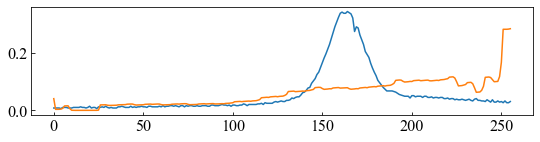

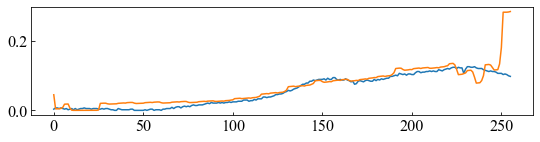

normal:3.6473648672690615
tensor([-2.6324,  5.0243, -6.1830], grad_fn=<AddBackward0>)


IndexError: index 50 is out of bounds for axis 0 with size 50

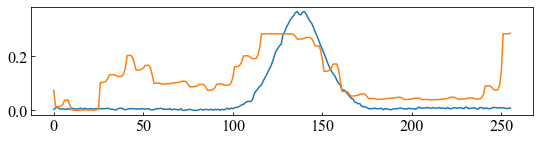

In [18]:
num = 1000
input_model = mainmodel.Autoencoder2()
# Dataset.savenumpy(data, test_data, anomaly_data, num)

new_model = mainmodel.Modeledit("Obrid_AE").read_model(input_model,"Obrid_AE/model_data/20211202/epoch1000.pth")
for i in range(anomaly_data.shape[0]):
    if i % 10 == 0:
        data0 =  torch.from_numpy((test_data[i]).astype(np.float32)).clone()
        test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()

        plt.figure(figsize=(9, 2))
        # data = data0.numpy()
        data = data0[np.newaxis, np.newaxis, :]
        recon = model(data).detach().numpy()
        plt.plot(data0.numpy())
        plt.plot(recon.flatten())
        plt.show()
        
        anomalypoint=sum(abs(recon.flatten()-data0.numpy()))
        print("normal:"+str(anomalypoint))
        if(anomalypoint>10):
            errorPoint 
            
        plt.figure(figsize=(9, 2))
        # data = test0.numpy()
        data = test0[np.newaxis, np.newaxis, :]
        recon = model(data).detach().numpy()
        plt.plot(test0.numpy())
        plt.plot(recon.flatten())
        print(model.encoder(data))

In [10]:
model.encoder

Sequential(
  (0): Conv1d(1, 1, kernel_size=(7,), stride=(5,))
  (1): ReLU()
  (2): Conv1d(1, 1, kernel_size=(5,), stride=(3,))
  (3): ReLU()
  (4): Flatten(start_dim=0, end_dim=-1)
  (5): Linear(in_features=16, out_features=3, bias=True)
)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
import numpy as np

In [5]:

new_model = mainmodel.Modeledit("Obrid_AE")
new_model.load_state_dict(torch.load(path), strict=False)
new_model= read_model(mainmodel.Autoencoder2(),"Obrid_AE/model_data/20210527/epoch1000.pth")
Dataset = dataset.dataset("Obrid_AE", "data")
data,test,anomaly = Dataset.loadnumpy(20210527,'1000')
print(anomaly.shape)
recon = new_model(data).detach().numpy()
plt.plot(recon.flatten())
plt.show()

AttributeError: 'Modeledit' object has no attribute 'load_state_dict'

In [23]:
type(new_model)

torch.nn.modules.module._IncompatibleKeys

## 背景差分のグラフ作成

In [5]:

import pandas as pd

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


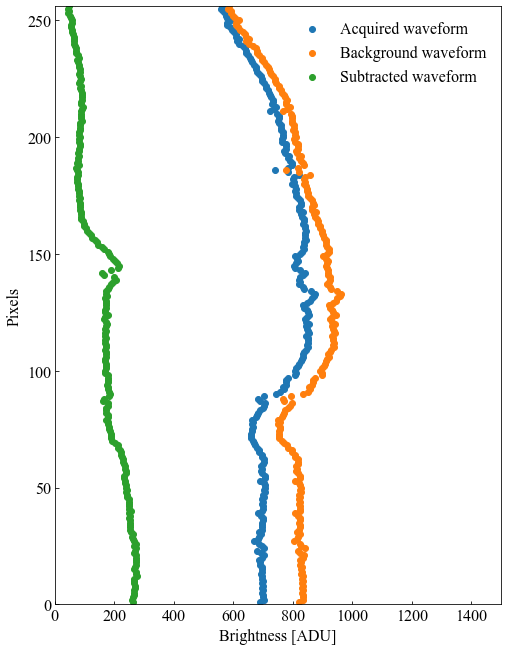

In [31]:
path = './Obrid_AE/シン実験5-12/早川/立/BRIGHTNESS216/sensor_val.csv'
data_df = pd.read_csv(path, header=None, engine="python")
data_diff = np.array(data_df.iloc[3:, 3].reset_index(drop = True).values,dtype = np.int64)
data_brightness = np.array(data_df.iloc[3:, 1].reset_index(drop = True).values,dtype = np.int64)
data_background = np.array(data_df.iloc[3:, 2].reset_index(drop = True).values,dtype = np.int64)
# plt.clf()
plt.figure(figsize=(8,11))

plt.xlim(0,1500)
plt.ylim(0,256)
plt.xlabel('Brightness [ADU]')
plt.ylabel('Pixels')
plt.scatter(data_brightness,range(256,0,-1),label='Acquired waveform')
plt.scatter(data_background,range(256,0,-1),label = 'Background waveform')
plt.scatter(data_diff,range(256,0,-1),label='Subtracted waveform')

plt.legend(edgecolor='white')

plt.savefig("diff.eps", bbox_inches="tight", pad_inches=0.05) 
plt.show()

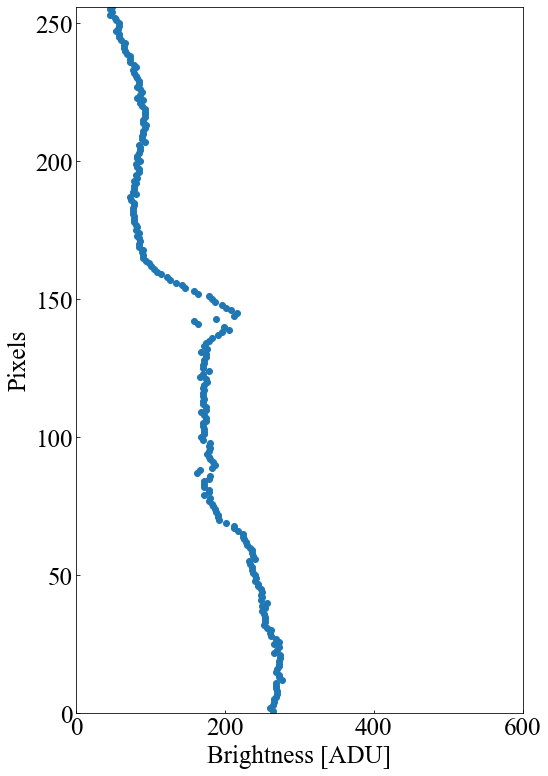

In [44]:
path = './Obrid_AE/シン実験5-12/早川/立/BRIGHTNESS216/sensor_val.csv'
data_df = pd.read_csv(path, header=None, engine="python")
data_diff = np.array(data_df.iloc[3:, 3].reset_index(drop = True).values,dtype = np.int64)
# data_brightness = np.array(data_df.iloc[3:, 1].reset_index(drop = True).values,dtype = np.int64)
# data_background = np.array(data_df.iloc[3:, 2].reset_index(drop = True).values,dtype = np.int64)
# plt.clf()
plt.figure(figsize=(8,13))
plt.rcParams['font.size'] = 25
plt.xlim(0,600)
plt.ylim(0,256)
plt.xlabel('Brightness [ADU]')
plt.ylabel('Pixels')
# plt.scatter(data_brightness,range(256,0,-1),label='Acquired waveform')
# plt.scatter(data_background,range(256,0,-1),label = 'Background waveform')
plt.scatter(data_diff,range(256,0,-1))

# plt.legend(edgecolor='white')

plt.savefig("stand.eps", bbox_inches="tight", pad_inches=0.05) 
plt.show()

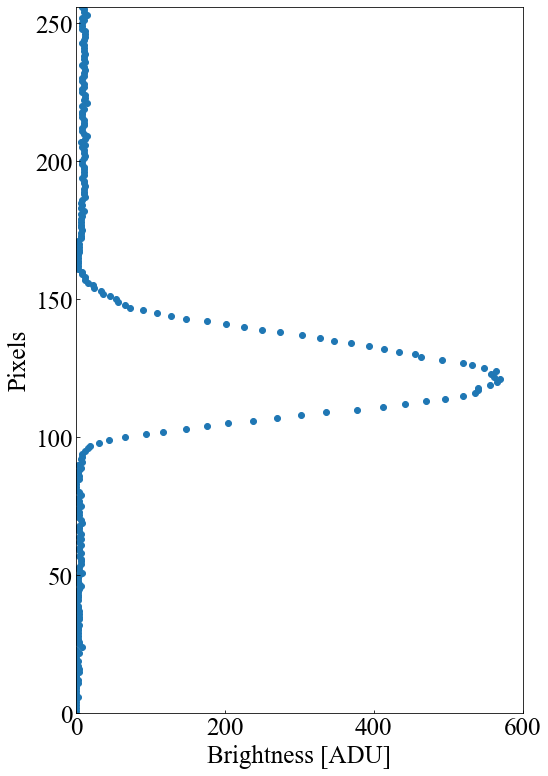

In [6]:
path = './Obrid_AE/シン実験5-12/早川/寝/BRIGHTNESS2210/sensor_val.csv'
data_df = pd.read_csv(path, header=None, engine="python")
data_diff = np.array(data_df.iloc[3:, 3].reset_index(drop = True).values,dtype = np.int64)
# data_brightness = np.array(data_df.iloc[3:, 1].reset_index(drop = True).values,dtype = np.int64)
# data_background = np.array(data_df.iloc[3:, 2].reset_index(drop = True).values,dtype = np.int64)
# plt.clf()
plt.figure(figsize=(8,13))
plt.rcParams['font.size'] = 25
plt.xlim(0,600)
plt.ylim(0,256)
plt.xlabel('Brightness [ADU]')
plt.ylabel('Pixels')
# plt.scatter(data_brightness,range(256,0,-1),label='Acquired waveform')
# plt.scatter(data_background,range(256,0,-1),label = 'Background waveform')
plt.scatter(data_diff,range(256,0,-1))

# plt.legend(edgecolor='white')

plt.savefig("falling.eps", bbox_inches="tight", pad_inches=0.05) 
plt.show()

## 英語論文

「この〜を〜」⇨This　はダメ
the 〜で始める

識別する:distinguish
    ❌discriminate⇨差別する

In [ ]:
Itは使わない　the sensorくらいの省略で済ませる